<a href="https://colab.research.google.com/github/raheelam98/Agentic_Chatbots_with_langgraph/blob/main/Agentic_Chatbots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Agentic Chatbots
Autonomous systems that perform tasks, make decisions, and interact with users with minimal human intervention. Leveraging advanced AI, they understand context, learn from interactions, and provide personalized responses

Install the required packages:

In [1]:
# install the required packages
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

API keys

In [2]:
# API Keys
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "agentic_chatbot"

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [3]:
# ChatGoogleGenerativeAI
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

In [4]:
# check llm is working
result = llm.invoke("hi")
result

AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-80e47cf9-8704-4679-af80-13bd4a0f0421-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

Chatbot with tools (part 2)

In [5]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [6]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

## Part 1: Build a Basic Chatbot

Create a chatbot that responds directly to user messages.

It is a large language model, trained by Google,

without access to real-time information (e.g., Karachi Weather) and

without retaining memory of previous interactions."

**`add_messages`** educer function in LangGraph. It's used to manage and update the list of messages in the state.

**Reducer Function**: In LangGraph, a reducer function like add_messages helps manage state changes. It takes the current state and an action as input, then returns a new state based on those inputs.

Usage in State Management: When you invoke a graph in LangGraph, **`add_messages`** is used to **append new messages to the existing list of messages in the state**.

**`add_message`** append, update, and remove messages in the existing list of messages in the state.

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

#add_messages : append new messages to the existing list of messages in the state in the graph.
# Define the State class with a list of messages
class State(TypedDict):
    messages: Annotated[list, add_messages]


# Create a StateGraph instance with the State type
graph_builder = StateGraph(State)

# create node of chatbot
# Define the chatbot function that uses the state and returns a response from the LLM
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# NOTE
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.

# Check if the node already exists before adding it
if "chatbot" not in graph_builder.nodes:
    graph_builder.add_node("chatbot", chatbot)
else:
    print("Node 'chatbot' already present.")

# # Adding nodes
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph = graph_builder.compile()


**Visualize the graph**

Use get_graph to obtain the graph.

Choose a draw method (draw_ascii or draw_png).

Ensure you have the required dependencies installed for the chosen draw method.

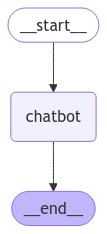

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Extracts the latest message from the use

In [ ]:
# Loop through each event in the stream of events from the graph
for event in graph.stream({"messages": [("user", "I am Raheela")]}):
    # Print the latest message content from the user
    print("EVENT:", list(event.values())[0]["messages"][-1].content)

EVENT: Hello Raheela! It's nice to meet you. What can I do for you today? 



Now let's run the chatbot!

**Tip:** You can exit the chat loop at any time by typing "quit", "exit", or "q".

In [ ]:
def stream_graph_updates(user_input: str):
    # Loop through each event in the stream of events from the graph based on user input
    for event in graph.stream({"messages": [("user", user_input)]}):
        # Loop through each value in the event
        for value in event.values():
            # Print the latest message content from the Assistant
            print("Assistant:", value["messages"][-1].content)

# Continuously prompt the user for input
while True:
    try:
        # Get input from the user
        user_input = input("User: ")
        # Check if the user wants to quit
        if user_input.lower() in ["quit", "exit", "q"]:
            # Print a goodbye message and break the loop
            print("Goodbye!")
            break

        # Call the stream_graph_updates function with the user input
        stream_graph_updates(user_input)
    except:
        # Fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        # Print the fallback user input
        print("User: " + user_input)
        # Call the stream_graph_updates function with the fallback user input
        stream_graph_updates(user_input)
        break


User: What do you know about LangGraph?
Assistant: I do not have access to real-time information, including specific knowledge about proprietary software like LangGraph. To give you the most accurate information, I need some context. 

**Could you please tell me more about what you'd like to know about LangGraph?** For example:

* **What is LangGraph?** (Is it a software, a service, a research project, etc.?)
* **What are you looking for information about?** (Its features, its purpose, its developers, etc.?)

Once I have a better understanding of your question, I can provide you with more relevant information. 



## Part 2: Enhancing the Chatbot with Tools

[Tavily Search Engine](https://python.langchain.com/docs/integrations/tools/tavily_search/), and set your [TAVILY_API_KEY](https://tavily.com/).

Added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.


#### Integrating tools for search results

Install the Required Packages to Add Tool (tavily-python and langchain_community) for Real-Time Search (e.g., Karachi Weather)

```bash
%%capture --no-stderr
%pip install -U tavily-python langchain_community
```

Setting the API key in the environment variable TAVILY_API_KEY

```bash
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
```

Next, define the tool

**`TavilySearchResults(max_results=2)`** initializes a search tool that retrieves and returns up to 2 search results.

Initializes a search tool that retrieves and returns up to 2 search results.
```bash
tool = TavilySearchResults(max_results=2)
tools = [tool]
```

**`bind_tools()`** Integrates the specified tools with the language model, enabling the model to invoke these tools during its execution

```bash
llm_with_tools = llm.bind_tools(tools)
```
This line integrates the tools list with the language model llm, resulting in a new instance (llm_with_tools) that can use these tools during its operations.

**`add_conditional_edges`** Define conditional edges for the chatbot node based on tool usage
```bash
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
```

**rm note**

**`ToolNode`** is a built-in function of LangGraph. We can create our own custom function that provides a list of tools such as a search engine, Excel file operations, weather search, or database search in SQL. To integrate these tools into LangGraph, pass them into a custom `ToolNode`. We’ll build our own `BasicToolNode` and replace LangGraph’s prebuilt `ToolNode` and `tools_condition` with it, using

ToolNode(tools=[your_tool]).


**ToolNode** is essentially a node within a workflow or graph that is designated to execute a specific tool or function when called.

**ToolNode** is a LangChain Runnable that takes graph state (with a list of messages) as input and outputs state update with the result of tool calls.

**ToolNode** is just a class that helps with this execution. You pass it your list of tools, and internally it stores them as name-function pairs.

**function call** provide external data to llm
add anything in function call

We can add data from our database or search for things on the web available in part 2

Note: The LLM never directly calls the tool. Instead, it generates a query and specifies which tool is required to run

Relationship between the LLM and LangGraph, and why the tool needs to be passed twice.

**LLM and LangGraph**

LangGraph has nodes.

The LLM doesn't know which tool to call by itself. LangGraph manages the tools.

To enable the LLM to call the tool, we bind the tool to the LLM.

The LLM then generates the query and specifies which tool is required to run.

LangGraph handles the actual tool invocation.

That's why we pass the tool twice:

(Part 2: Enhancing the Chatbot with Tools)

**Initializes a search tool that retrieves and returns up to 2 search results**
```bash
tool = TavilySearchResults(max_results=2)
tools = [tool]
```

**Modification: tell the LLM which tools it can call**
```bash
llm_with_tools = llm.bind_tools(tools)
```

**`add_conditional_edges()`** is a function used to add conditional connections between nodes in a graph, based on specific conditions. It helps create dynamic workflows where the next step depends on certain criteria being met.

**`graph_builder.add_conditional_edges("chatbot", tools_condition)`**

Purpose: Adds an edge from the `chatbot` node to another node, only if the `tools_condition` is satisfied.

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

#(part 1 : Basic Chatbot)
#add_messages : append new messages to the existing list of messages in the state in the graph.
# Define the State class with a list of messages (part 1)
class State(TypedDict):
    messages: Annotated[list, add_messages]

#(part 1 : Basic Chatbot)
# Create a StateGraph instance with the State type (part 1)
graph_builder = StateGraph(State)

# (Part 2: Enhancing the Chatbot with Tools)
# Initializes a search tool that retrieves and returns up to 2 search results.
tool = TavilySearchResults(max_results=2)
tools = [tool]

# (Part 2: Enhancing the Chatbot with Tools)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

#(part 1 : Basic Chatbot)
# Define the chatbot function that uses the state and returns a response from the LLM
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

#(part 1 : Basic Chatbot)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_node("chatbot", chatbot)

# (Part 2: Enhancing the Chatbot with Tools)
# Add the tools node to the graph
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# (Part 2: Enhancing the Chatbot with Tools)
# Define conditional edges for the chatbot node based on tool usage
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

#(part 1 : Basic Chatbot)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# Define the starting point of the graph as the chatbot node
graph_builder.add_edge(START, "chatbot")

#(part 1 : Basic Chatbot)
# Compile the graph
graph = graph_builder.compile()

 **Visualize the graph**

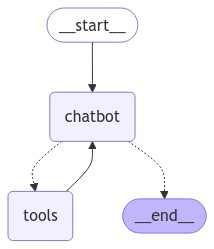

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now we can ask the bot questions outside its training data.

Chatbot Loop with Real-Time User Input Processing and No Memory Retention

In [ ]:
# 1) Web search is available. 2) Does not maintain chat history (no memory).
while True:
    try:
        # Prompt the user for input
        user_input = input("User: ")
        # Check if the user wants to quit
        if user_input.lower() in ["quit", "exit", "q"]:
            # Print a goodbye message and break the loop
            print("Goodbye!")
            break

        # Call the stream_graph_updates function with the user input
        stream_graph_updates(user_input)
    except:
        # Fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        # Print the fallback user input
        print("User: " + user_input)
        # Call the stream_graph_updates function with the fallback user input
        stream_graph_updates(user_input)
        break


User: q
Goodbye!


## Part 3: Adding Memory to the Chatbot

**Memory checkpointing**  
provides state to the chatbot, allowing it to maintain the history based on `thread_id`.


Add memory saver for checkpointing:
```bash
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
```

Compile the graph with memory checkpointing:
```bash
graph = graph_builder.compile(checkpointer=memory)
```
Checkpointing the state as the graph works through each node.

**`graph = graph_builder.compile(checkpointer=MemorySaver())`** compiles the graph with memory checkpointing, allowing it to save and restore the state of the graph's nodes during its execution.

To interact with the bot, first, pick a thread to use as the key for this conversation:
```bash
config = {"configurable": {"thread_id": "1"}}
```

The **chatbot can remember the state of the conversation within a given thread** but won't retain context if the thread ID is changed.


In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START # , END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# (Part 3: Adding Memory to the Chatbot)
# Add memory saver for checkpointing
memory = MemorySaver()

# (Part 1: Basic Chatbot)
#add_messages : append new messages to the existing list of messages in the state in the graph.
# Define the State class with a list of messages (part 1)
class State(TypedDict):
    messages: Annotated[list, add_messages]

# (Part 1: Basic Chatbot)
# Create a StateGraph instance with the State type (part 1)
graph_builder = StateGraph(State)

# (Part 2: Enhancing the Chatbot with Tools)
# Initializes a search tool that retrieves and returns up to 2 search results.
tool = TavilySearchResults(max_results=2)
tools = [tool]

# (Part 2: Enhancing the Chatbot with Tools)
# Integrate LLM with bind_tools for web search
llm_with_tools = llm.bind_tools(tools)

# (Part 1: Basic Chatbot)
# Define the chatbot function that uses the state and returns a response from the LLM
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# (Part 1: Basic Chatbot)
# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# (Part 2: Enhancing the Chatbot with Tools)
# Add the tools node to the graph
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# (Part 2: Enhancing the Chatbot with Tools)
# Define conditional edges for the chatbot node based on tool usage
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# (Part 1: Basic Chatbot)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# (Part 1: Basic Chatbot)
# Define the starting point of the graph as the chatbot node
graph_builder.add_edge(START, "chatbot")

# (Part 3: Adding Memory to the Chatbot)
# Compile the graph with memory checkpointing
graph = graph_builder.compile(checkpointer=MemorySaver())


 **Visualize the graph**

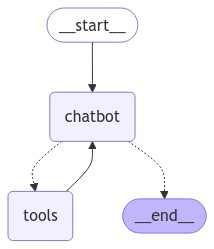

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now you can interact with your bot! First, pick a thread to use as the key for this conversation.

In [ ]:
config = {"configurable": {"thread_id": "1"}}

Next, call your chat bot.

In [ ]:
user_input = "Hi there! My name is Raheela."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Loop through each event in the stream
for event in events:
    # Print the latest message content from the event
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Raheela.
================================== Ai Message ==================================

Hi Raheela, nice to meet you! 👋  What can I do for you today? 😊


In [ ]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Loop through each event in the stream
for event in events:
    # Print the latest message content from the event
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I will try my best to remember your name, Raheela! 😊  Is there anything else I can help you with?


The **chatbot can remember the state of the conversation within a given thread** but won't retain context if the thread ID is changed.

In [ ]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I am sorry, I do not have memory of past conversations. I am a large language model, and I do not have the ability to store personal information like names.


goes into a checkpoint? To inspect a graph's state for a given config at any time, call get_state(config).

```bash
# Fetch the current state of the graph for the given configuration
snapshot = graph.get_state(config)

# Inspect the snapshot
snapshot

```

Retrieve the next node to execute (empty if the graph ended this turn)

```bash
snapshot.next
```
(since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

## Part 4: Human-in-the-loop

**Freezer and un unfreez node**

LangGraph's interrupt_before functionality to always break the tool node.

**`graph = graph_builder.compile(checkpointer=memory, interrupt_before=["tools"])`**

**`interrupt_before=["tools"]`** This is new! it pose the node and can perform read and write opration

Note: can also interrupt __after__ tools, if desired.
**`interrupt_after=["tools"]`** it pose the node and can perform read and write opration


**`get_state()`**  Retrieve the current state of a particular object

**`.next`** Find out what the next node to execute

**`.config`** Show the current configuration of the state

**`.value`**  Show all values

**inspect the graph state to confirm it worked**

* `snapshot = graph.get_state(config)`  # Retrieve the current state of the graph
* `snapshot.config`  # Show the current configuration of the state
* `snapshot.next`  # Retrieve the next node that will execute in the graph. If the graph ended this turn, next will be empty


```bash
snapshot = graph.get_state(config)  # Retrieve the current state or status of the graph
snapshot.next  # Find out what the next node to execute is
snapshot.config  # Show the current configuration of the state
snapshot.values  # Show values
snapshot.values['messages']  # Show messages

existing_message = snapshot.values["messages"][-1]  # Find out the last message
existing_message.pretty_print()  # Print message

existing_message.tool_calls  # Get tool data
```

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START # , END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


# (Part 1: Basic Chatbot)
#add_messages : append new messages to the existing list of messages in the state in the graph.
# Define the State class with a list of messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

# (Part 1: Basic Chatbot)
# Create a StateGraph instance with the State type
graph_builder = StateGraph(State)


# (Part 2: Enhancing the Chatbot with Tools)
# Initializes a search tool that retrieves and returns up to 2 search results.
tool = TavilySearchResults(max_results=2)
tools = [tool]

# (Part 2: Enhancing the Chatbot with Tools)
# Bind the tools to the LLM for web search functionality
llm_with_tools = llm.bind_tools(tools)

# (Part 1: Basic Chatbot)
# Define the chatbot function that uses the state and returns a response from the LLM
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# (Part 1: Basic Chatbot)
# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# (Part 2: Enhancing the Chatbot with Tools)
# Add the tools node to the graph
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# (Part 2: Enhancing the Chatbot with Tools)
# Define conditional edges for the chatbot node based on tool usage
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# (Part 1: Basic Chatbot)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# (Part 1: Basic Chatbot)
# Define the starting point of the graph as the chatbot node
graph_builder.add_edge(START, "chatbot")


In [ ]:
# (Part 3: Adding Memory to the Chatbot)
# Add memory saver for checkpointing
memory = MemorySaver()

# Compile the graph with memory checkpointing and interrupt configurations
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new! (Part 4: Human-in-the-loop)
    # Interrupt before running tools node
    interrupt_before=["tools"],  #interrupt_before the tools node
)

In [ ]:
print(graph)

**Visualize the graph**

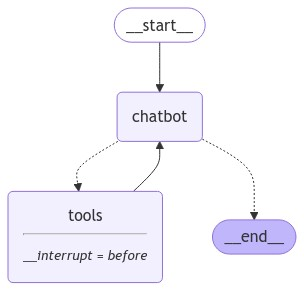

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
# User input example
user_input = "I'm learning LangGraph. Could you do some research on it for me?"

# Configuration for the thread ID
config = {"configurable": {"thread_id": "1"}}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Loop through each event in the stream
for event in events:
    if "messages" in event:
        # Print the latest message content from the event
        event["messages"][-1].pretty_print()


================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

It sounds like you're embarking on a journey into the world of LangGraph! To help you learn effectively, I need a little more direction.  

What specifically about LangGraph are you curious about?  For example, are you interested in:

* **The core concepts?**  Like how it represents text as a graph, the different types of nodes and edges, and how it uses graph algorithms for analysis?
* **Practical applications?**  Maybe you'd like to see how it's used for semantic search, text summarization, or knowledge graph construction?
* **Code examples and tutorials?**  Are you looking for hands-on guidance on how to build a LangGraph from text data, or how to use it for specific tasks?
* **The latest research and advancements?**  Do you want to explore cutting-edge deve

In [ ]:
#inspect the graph state to confirm it worked.
snapshot = graph.get_state(config)  # Retrieve the current state or status of the graph
snapshot.next   # Retrieve the next node that will execute in the graph

()

Notice that unlike last time, the "next" node is set to 'tools'. We've interrupted here! Let's check the tool invocation.

In [ ]:
existing_message = snapshot.values["messages"][-1]  # Find out the last message
existing_message.pretty_print()  # Print message

print("\nexisting message - tool_call")
existing_message.tool_calls  # Get tool data

================================== Ai Message ==================================

It sounds like you're embarking on a journey into the world of LangGraph! To help you learn effectively, I need a little more direction.  

What specifically about LangGraph are you curious about?  For example, are you interested in:

* **The core concepts?**  Like how it represents text as a graph, the different types of nodes and edges, and how it uses graph algorithms for analysis?
* **Practical applications?**  Maybe you'd like to see how it's used for semantic search, text summarization, or knowledge graph construction?
* **Code examples and tutorials?**  Are you looking for hands-on guidance on how to build a LangGraph from text data, or how to use it for specific tasks?
* **The latest research and advancements?**  Do you want to explore cutting-edge developments in LangGraph and its potential?

Tell me more about your specific interests, and I'll do my best to provide you with helpful information a

[]

resume, and check work flow


In [ ]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

It sounds like you're embarking on a journey into the world of LangGraph! To help you learn effectively, I need a little more direction.  

What specifically about LangGraph are you curious about?  For example, are you interested in:

* **The core concepts?**  Like how it represents text as a graph, the different types of nodes and edges, and how it uses graph algorithms for analysis?
* **Practical applications?**  Maybe you'd like to see how it's used for semantic search, text summarization, or knowledge graph construction?
* **Code examples and tutorials?**  Are you looking for hands-on guidance on how to build a LangGraph from text data, or how to use it for specific tasks?
* **The latest research and advancements?**  Do you want to explore cutting-edge developments in LangGraph and its potential?

Tell me more about your specific interests, and I'll do my best to provide you with helpful information a

`None` will append nothing new to the current state, letting it resume as if it had never been interrupted

```bash
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
```        

## Part 5: Manually Updating the State

read the state (part 4) now write the state

In [ ]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START #, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


# (Part 1: Basic Chatbot)
#add_messages : append new messages to the existing list of messages in the state in the graph.
# Define the State class with a list of messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

# (Part 1: Basic Chatbot)
# Create a StateGraph instance with the State type
graph_builder = StateGraph(State)

# (Part 1: Basic Chatbot)
# Create a StateGraph instance with the State type
tool = TavilySearchResults(max_results=2)
tools = [tool]

# (Part 2: Enhancing the Chatbot with Tools)
# Integrate LLM with bind_tools for web search
llm_with_tools = llm.bind_tools(tools)

# (Part 1: Basic Chatbot)
# Define the chatbot function that uses the state and returns a response from the LLM
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# (Part 1: Basic Chatbot)
# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# (Part 2: Enhancing the Chatbot with Tools)
# Add the tools node to the graph
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

# (Part 2: Enhancing the Chatbot with Tools)
# Define conditional edges for the chatbot node based on tool usage
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# (Part 1: Basic Chatbot)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

#(Part 1: Basic Chatbot)
# Define the starting point of the graph as the chatbot node
graph_builder.add_edge(START, "chatbot")

# (Part 3: Adding Memory to the Chatbot)
# Add memory saver for checkpointing
memory = MemorySaver()

# Compile the graph with memory checkpointing and interrupt configurations
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new! (Part 4: Human-in-the-loop)
    # Interrupt before running tools node
    interrupt_before=["tools"],  #interrupt_before the tools node
)

# User input example
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)

# Loop through each event in the stream
for event in events:
    if "messages" in event:
        # Print the latest message content from the event
        event["messages"][-1].pretty_print()

In [ ]:
# Fetch the current state of the graph for the given configuration

snapshot = graph.get_state(config)  # Retrieve the current state or status of the graph
print("snapshot ", snapshot)

existing_message = snapshot.values["messages"][-1]  # Retrieve the most recent message from the snapshot's values
existing_message.pretty_print()   # Print the content of the most recent message

snapshot  StateSnapshot(values={'messages': [HumanMessage(content="I'm learning LangGraph. Could you do some research on it for me?", additional_kwargs={}, response_metadata={}, id='7d4e299d-ae7f-466d-9df0-9f40e1a39669'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "LangGraph"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-72b9cfbd-cfcf-4074-9267-53a426c23721-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': 'ef3

**Note**
query: LangGraph,  
now update the query before go to the tool

Save the state new_messages[-1]
than update state `graph.get_state(config).values["messages"][-2:]`

```bash
new_messages = [
 ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),  AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state( config, {"messages": new_messages},)
```

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage

tavily_answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)

new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=tavily_answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=tavily_answer),
]

print("new messages ", new_messages)

new_messages[-1].pretty_print()

# update state: pose graph and update state
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages; - get the state after update")
print(graph.get_state(config).values["messages"][-2:])

new messages  [ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', tool_call_id='ef33c946-34d0-4a5f-b454-c653d147553c'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={})]
================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages; - get the state after update
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='718af78a-3b35-41b5-a12b-1090b76d0be2', tool_call_id='ef33c946-34d0-4a5f-b454-c653d147553c'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='02842b3c-8131-4770-8652-68abe9c4cf46')]


In [ ]:
# update state and define node to restart update state
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},  # define state
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
     as_node="chatbot",  # define node to restart after update state
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9eaa7-ef8c-6394-8003-6e6cf824a6d8'}}

**Visualize the graph**

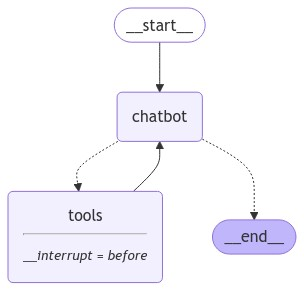

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**overwrite existing messages**

In [ ]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (7727f54c-68a3-4c3c-9ef4-928a248d8f90)
 Call ID: 7727f54c-68a3-4c3c-9ef4-928a248d8f90
  Args:
    query: LangGraph


**Next,** let's update the tool invocation for our agent. Maybe we want to search for human-in-the-loop workflows in particular.

In [ ]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original - existing_message" , existing_message)
print("\nMessage ID", existing_message.id)
print("\nExisting_message : ",existing_message.tool_calls[0])

new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph human-in-the-loop workflow"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("\nUpdated ")
print(new_message.tool_calls[0])
print("\nMessage ID", new_message.id)

graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original - existing_message content='' additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "LangGraph"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}]} id='run-3d350f1f-6331-4885-a20e-6614125adcbc-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '7727f54c-68a3-4c3c-9ef4-928a248d8f90', 'type': 'tool_call'}] usage_metadata={'input_tokens': 91, 'output_tokens': 21, 'total_tokens': 112, 'input_token_details': {'cache_read': 0}}

Message ID run-3d350f1f-6331-

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph human-in-the-loop workflow'},
  'id': '7727f54c-68a3-4c3c-9ef4-928a248d8f90',
  'type': 'tool_call'}]

# Part 6: Customizing State



**add_messages** : append new messages to the existing list of messages in the state in the graph.
Define the State class with a list of messages
```bash
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool
```

(Part 6: Customizing State)

**`ask_human: bool`** flag indicates whether only a human can give instructions, true means only a human can give instructions

Bind the llm to a tool definition, a pydantic model, or a json schema
```bash
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])
```
**`[RequestAssistance]`**  human use RequestAssistance Schema

Now llm triger both Tool and RequestAssistance Schema

In [38]:
# Import necessary modules
from langgraph.graph import START, END, StateGraph  # Import START and StateGraph for building the graph
from langgraph.prebuilt import tools_condition, ToolNode  # Import tools_condition and ToolNode

#from langgraph.graph.state import CompiledStateGraph  # Import CompiledStateGraph for compiling the graph

from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, AIMessage , ToolMessage

from pydantic import BaseModel
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph.message import add_messages


# STEP 1
# (Part 1 : Basic Chatbot)
# add_messages: Append new messages to the existing list of messages in the state in the graph.
# Define the State class with a list of messages
class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag indicates whether only a human can give instructions
    ask_human: bool   # (Part 6) True means only a human can give instructions

# STEP 2
class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """
    request: str

# STEP 3
tool = TavilySearchResults(max_results=2)
tools = [tool]

# Bind the LLM (Large Language Model) to a tool definition, a pydantic model, or a JSON schema
# Now the LLM is capable of triggering both the Tool and the RequestAssistance Schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

# STEP 4 :-  default ask_human = False, LLM tells it is flase or true
# Define the chatbot node with modification of ask_human flag
# if response call tool_call then ask_human = true then it routes human route
# Define the chatbot function which uses the bound LLM and tools
def chatbot(state: State):
    # Invoke the LLM with the state messages
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False       # by default ask_human = False
    # Check if the response includes tool calls and if the first tool call is for RequestAssistance
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    # Return the updated state with the response and ask_human flag
    return {"messages": [response], "ask_human": ask_human}

# STEP 5 :- create chatbot and tool node
# Create the graph builder and add the chatbot and tools nodes to the graph, same as before.
graph_builder = StateGraph(State)

# Add the chatbot node to the state graph
graph_builder.add_node("chatbot", chatbot)

# Add the tools node to the state graph with the specified tool
graph_builder.add_node("tools", ToolNode(tools=[tool]))

# STEP 6 :- create human node
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

# First create helper function for human_node functionality
def human_node(state: State):
    new_messages = []    # Create dictionary
    # Check if the last message from state is from ToolMessage
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to let the LLM continue.
        # If the last message from state is not from ToolMessage
        # then append the generic response, No response from human.
        # Human node triggered but did not get the response.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False, # To protect from infinite loop if no response from human
    }

# Add the human node to the state graph and pass human_node function
graph_builder.add_node("human", human_node)

# STEP 7 :- conditional logic
# When chatbot triggers for human: if ask_human is true, return human
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, route as before
    return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

# STEP 8 :
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)


**Visualize the graph**

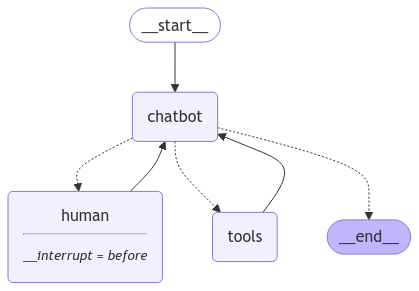

In [24]:
from IPython.display import Image, display  # Import IPython display classe

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's see this graph in action.

In [11]:
# user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
# config = {"configurable": {"thread_id": "1"}}
# # The config is the **second positional argument** to stream() or invoke()!
# events = graph.stream(
#     {"messages": [("user", user_input)]}, config, stream_mode="values"
# )
# for event in events:
#     if "messages" in event:
#         event["messages"][-1].pretty_print()

In [39]:
# User input message
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"

# Configuration dictionary specifying the thread ID
config = {"configurable": {"thread_id": "1"}}

# The config is the **second positional argument** to stream() or invoke()!
# Stream the events from the graph using the provided user input and configuration
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

# Iterate through the returned events
for event in events:
    # Check if the event contains messages
    if "messages" in event:
        # Print the last message in the event in a formatted manner
        event["messages"][-1].pretty_print()


================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (e5dd48ee-ae77-45b9-a906-83e7b8cdc0ef)
 Call ID: e5dd48ee-ae77-45b9-a906-83e7b8cdc0ef
  Args:
    request: I need some expert guidance for building this AI agent.


**Notice:** the LLM has invoked the "`RequestAssistance`" tool we provided it, and the interrupt has been set. Let's inspect the graph state to confirm.

In [40]:
#inspect the graph state to confirm it worked.
snapshot = graph.get_state(config)  # Retrieve the current state of the graph
snapshot.next   # Retrieve the next node that will execute in the graph

('human',)

The graph state is indeed **interrupted** before the `'human'` node. We can act as the "expert" in this scenario and manually update the state by adding a new ToolMessage with our input.

Next, respond to the chatbot's request by:
1. Creating a `ToolMessage` with our response. This will be passed back to the `chatbot`.
2. Calling `update_state` to manually update the graph state.

In [41]:
# Get the last AI message from the snapshot values
ai_message = snapshot.values["messages"][-1]

# Prepare the human response message
human_response = (
    "We, the experts, are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

# Create a tool message using the human response and AI message
tool_message = create_response(human_response, ai_message)

# Update the graph state with the new tool message using the specified configuration
graph.update_state(config, {"messages": [tool_message]})


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa457b-f77a-62f7-8002-03301471984b'}}

Next, **resume** the graph by invoking it with `None` as the inputs.

In [42]:
# Stream the events from the graph using the provided configuration
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts, are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts, are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

OK. I've requested assistance from an expert.  They recommend checking out LangGraph for building your AI agent, as it's more reliable and extensible than simpler agents.


## Part 7: Time Travel

In [ ]:
from typing import Annotated, Literal

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage

from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,  START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]

# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

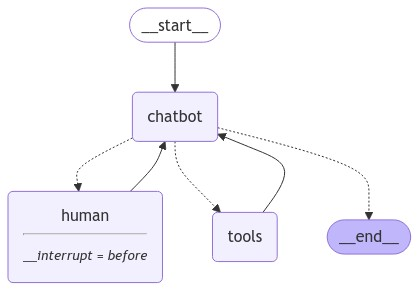

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [ ]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (784e9069-f9f0-4af8-b9e8-7c2377f854ff)
 Call ID: 784e9069-f9f0-4af8-b9e8-7c2377f854ff
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to build agent and multi-agent workflows."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agen

In [ ]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That's a great idea! LangGraph is well-suited for building autonomous agents. It allows you to define the agent's actions, goals, and how it interacts with its environment. 

What kind of autonomous agent are you thinking of building?  I'd be happy to brainstorm some ideas with you or help you find resources to get started.


In [ ]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state


Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


**Notice** that checkpoints are saved for every step of the graph. This __spans invocations__ so you can rewind across a full thread's history. We've picked out `to_replay` as a state to resume from. This is the state after the `chatbot` node in the second graph invocation above.

Resuming from this point should call the **action** node next.

In [ ]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef9f7a8-d671-63e0-8006-864e4fc00ca0'}}


**Notice** that the checkpoint's config (`to_replay.config`) contains a `checkpoint_id` **timestamp**. Providing this `checkpoint_id` value tells LangGraph's checkpointer to **load** the state from that moment in time. Let's try it below:

In [ ]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

That's a great idea! LangGraph is well-suited for building autonomous agents. It allows you to define the agent's actions, goals, and how it interacts with its environment. 

What kind of autonomous agent are you thinking of building?  I'd be happy to brainstorm some ideas with you or help you find resources to get started.


**Revision**

In [ ]:
#
# STEP 4
# Define the chatbot function which uses the bound LLM and tools
def chatbot(state: State):
    # Invoke the LLM with the state messages
    response = llm_with_tools.invoke("Connect me with a LangGraph Expart for paid  Project")

response.pretty_print()


================================== Ai Message ==================================

Hello there! How can I help you today?
